# Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import warnings


# Load environment variables
_ = load_dotenv()

/Users/aryasmc/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configuration to suppress warnings
warnings.filterwarnings('ignore')

# Additional configurations for better control over visualizations (optional)
plt.style.use('ggplot')  # For ggplot-like style in plots
pd.options.display.max_columns = None  # Ensure all columns are visible when displaying DataFrames


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

## Load the Dateset

In [4]:
# Define the path to the dataset
file_path = 'RAW_Data/main_data.csv'

# Load the dataset
df = pd.read_csv(file_path)

In [5]:
# Display the first few rows of the dataframe and the counts of unique product IDs
print("First few rows of the dataset:")
print(df.head())
print("\nCount of unique product IDs:")
print(df['product_id'].value_counts())

First few rows of the dataset:
   Unnamed: 0        time       low      high      open     close  \
0           0  2021-12-27  50480.00  52100.00  50804.33  50717.77   
1           1  2021-12-26  49460.00  51295.33  50428.31  50801.79   
2           2  2021-12-25  50191.84  51171.68  50852.31  50428.31   
3           3  2021-12-24  50445.55  51878.60  50842.06  50851.38   
4           4  2021-12-23  48032.16  51397.82  48608.61  50842.20   

         volume  price_change  average_price  volatitlity product_id  
0  11596.914682        -86.56      51290.000     3.209192    BTC-USD  
1   6863.394738        373.48      50377.665     3.710736    BTC-USD  
2   5550.571532       -424.00      50681.760     1.952190    BTC-USD  
3  11690.454182          9.32      51162.075     2.840786    BTC-USD  
4  16627.046280       2233.59      49714.990     7.007097    BTC-USD  

Count of unique product IDs:
product_id
BTC-USD     1084
ETH-USD     1084
SOL-USD     1084
ADA-USD     1084
LINK-USD    1084
LT

### Cleaning and Pre-processing

In [6]:
# Drop the 'Unnamed: 0' column
df.drop(columns='Unnamed: 0', inplace=True)

# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Extracting year, month, and day of week from the 'time' column
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day_of_week'] = df['time'].dt.dayofweek  # Monday=0, Sunday=6

# Calculate percentage change in closing prices
df['percentage_change'] = df['close'].pct_change() * 100
df['percentage_change'].fillna(0, inplace=True)  # Replace NaN values with 0 for the initial change

# Check for missing values
missing_data = df.isnull().sum()

# Display the cleaned data and any missing values along with the new date-time features
print("Cleaned Data with Date-Time Features:")
print(df.head())
print("\nMissing data summary:")
print(missing_data)


Cleaned Data with Date-Time Features:
        time       low      high      open     close        volume  \
0 2021-12-27  50480.00  52100.00  50804.33  50717.77  11596.914682   
1 2021-12-26  49460.00  51295.33  50428.31  50801.79   6863.394738   
2 2021-12-25  50191.84  51171.68  50852.31  50428.31   5550.571532   
3 2021-12-24  50445.55  51878.60  50842.06  50851.38  11690.454182   
4 2021-12-23  48032.16  51397.82  48608.61  50842.20  16627.046280   

   price_change  average_price  volatitlity product_id  year  month  \
0        -86.56      51290.000     3.209192    BTC-USD  2021     12   
1        373.48      50377.665     3.710736    BTC-USD  2021     12   
2       -424.00      50681.760     1.952190    BTC-USD  2021     12   
3          9.32      51162.075     2.840786    BTC-USD  2021     12   
4       2233.59      49714.990     7.007097    BTC-USD  2021     12   

   day_of_week  percentage_change  
0            0           0.000000  
1            6           0.165662  
2     

## EDA

In [7]:
# Display data types of each column
print("Data Types:")
print(df.dtypes)

# Get a statistical summary of the numerical columns
print("\nStatistical Summary:")
print(df.describe())

Data Types:
time                 datetime64[ns]
low                         float64
high                        float64
open                        float64
close                       float64
volume                      float64
price_change                float64
average_price               float64
volatitlity                 float64
product_id                   object
year                          int32
month                         int32
day_of_week                   int32
percentage_change           float64
dtype: object

Statistical Summary:
                                time           low         high          open  \
count                           6847   6847.000000   6847.00000   6847.000000   
mean   2023-01-11 15:27:40.931794944   6095.514346   6378.80187   6240.195701   
min              2021-06-28 00:00:00      0.230000      0.24610      0.241900   
25%              2022-04-10 00:00:00      6.801000      7.27650      7.031500   
50%              2023-01-22 00:00:00     66

### Observarions:
- Data Types: 
All data types appear appropriate for their respective fields. Numerical data is stored as float64, which is suitable for statistical computations, and time as datetime64[ns] is ideal for time-series analysis.

- Statistical Anomalies:
The min values for columns like low, high, open, close, and especially volume have extremely low values (close to zero in some cases), which might be outliers or errors, especially if they don't align with typical values for those cryptocurrencies.
The std (standard deviation) for some columns is quite high relative to their means, indicating significant variability which could be due to outliers or market volatility.

- Potential Outliers:
The maximum values in low, high, open, close, and particularly volume and price_change are exceedingly high. For example, the maximum volume is around 421 million, which could be valid but is worth a deeper look to ensure it's not skewing the analysis.

### Outlier Detection

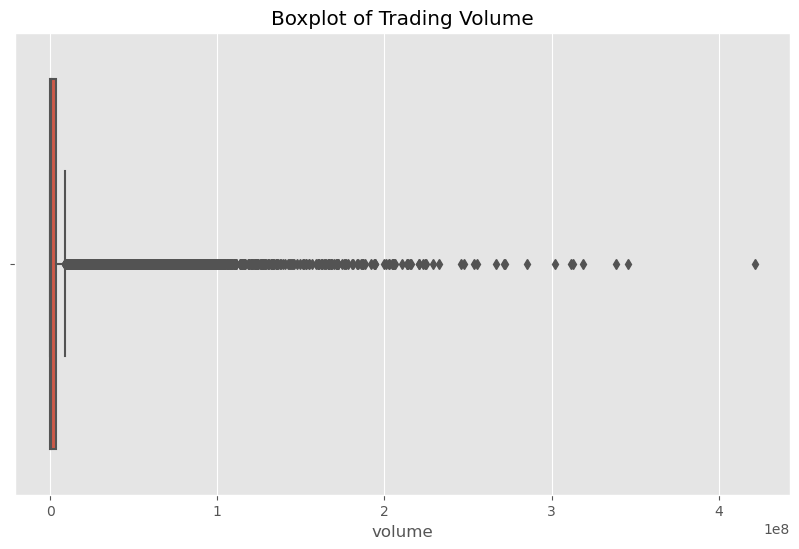

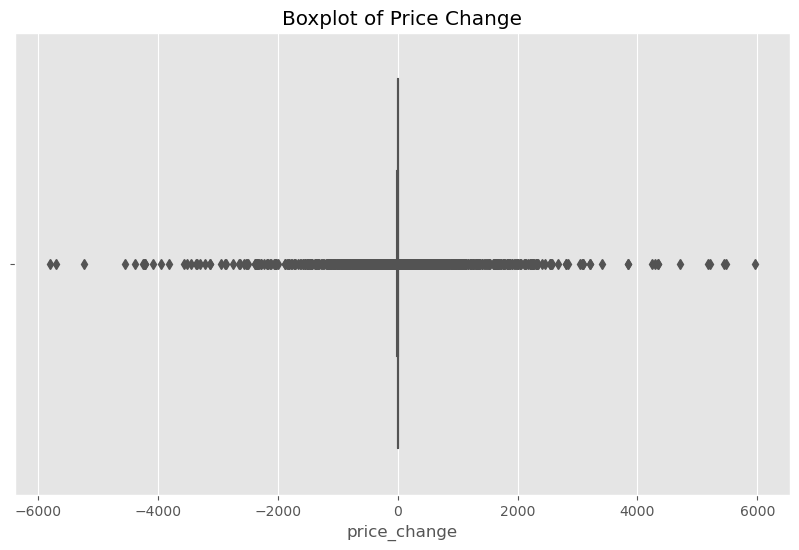

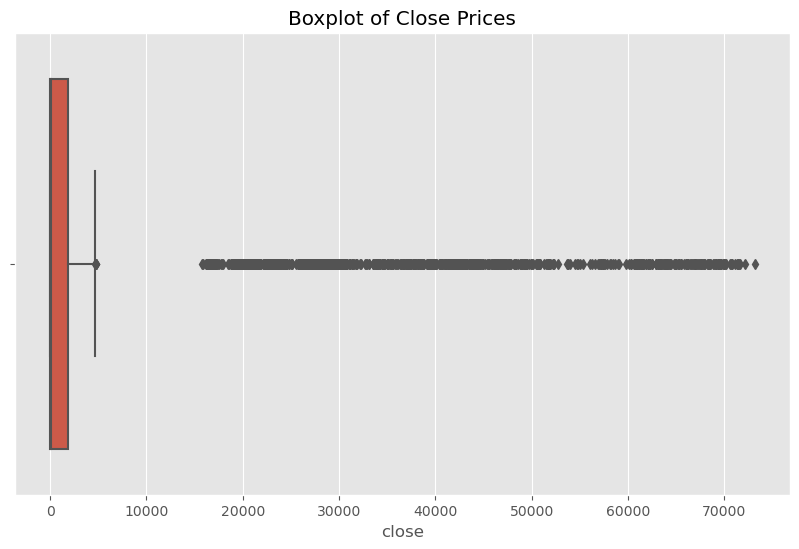

In [8]:
# Plotting the distribution of 'volume'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['volume'])
plt.title('Boxplot of Trading Volume')
plt.show()

# Plotting the distribution of 'price_change'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['price_change'])
plt.title('Boxplot of Price Change')
plt.show()

# Plotting the distribution of 'close'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['close'])
plt.title('Boxplot of Close Prices')
plt.show()

### Calculating the Correlation Matrix

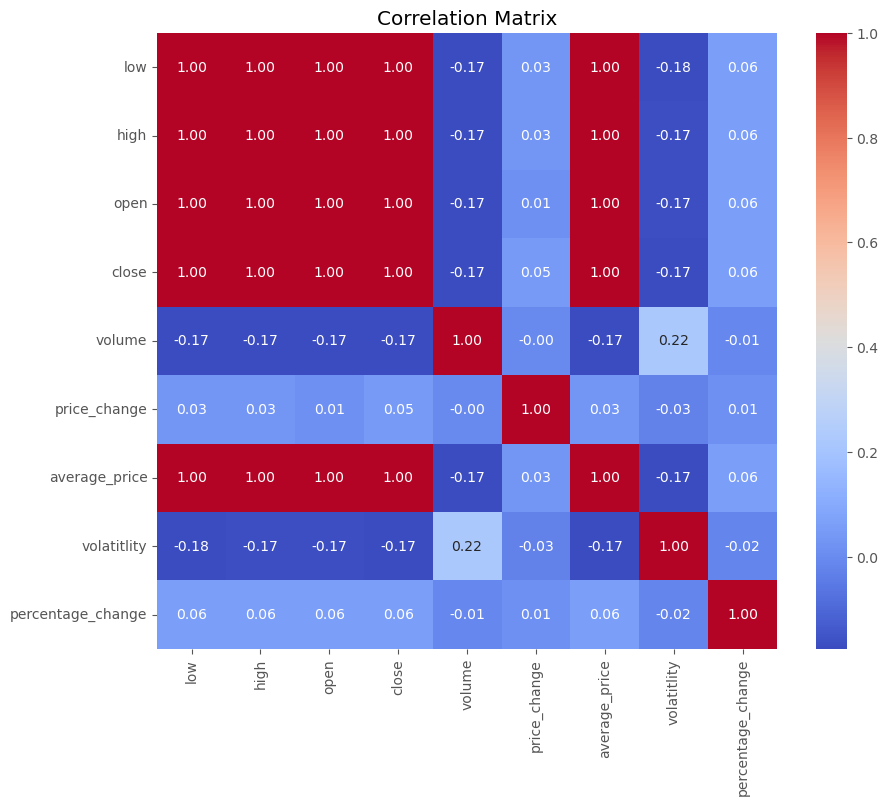

In [9]:
# Exclude non-numeric columns and calculate correlations
numeric_df = df.select_dtypes(include=['float64', 'int64'])  # This ensures only numeric columns are included
corr = numeric_df.corr()

# Heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#### Observations

- High Correlation Among Price Metrics: The low, high, open, close, and average_price exhibit perfect correlations (1.00) with each other. This is expected as these variables are all directly related to the price and often move together within the same trading period.

- Volume and Volatility: Volume shows a positive correlation with volatility (0.22), suggesting that higher trading volumes might be associated with greater price fluctuations within the period. This relationship could be useful for predictive modeling.

- Percentage Change: The percentage_change column shows relatively low correlation with other variables, indicating it might provide unique information for predictive modeling beyond what is captured by the absolute price levels.

#### Implications for Modeling
- Redundancy in Features: The high correlation among the price metrics suggests redundancy. For modeling purposes, we might consider using just one of the price metrics (e.g., close) or an engineered feature that captures the essence of all (like average_price).

- Feature Selection for Model: Given the unique information provided by percentage_change, this should definitely be included in our predictive models. The correlation with volume and volatility also suggests these features could be important.

- Potential for Multicollinearity: The high correlations among some predictors might lead to multicollinearity if we use linear models. We should consider this when selecting the type of model or during feature selection/preparation.

### Feature Engineering, Technical Indicators and Price Ratios

In [10]:
# Calculate Simple Moving Average (SMA)
df['sma_20'] = df['close'].rolling(window=20).mean()

# Calculate Relative Strength Index (RSI)
delta = df['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['rsi_14'] = 100 - (100 / (1 + rs))

# Calculate MACD (Moving Average Convergence Divergence)
df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()
df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
df['macd_line'] = df['ema12'] - df['ema26']
df['signal_line'] = df['macd_line'].ewm(span=9, adjust=False).mean()
df['macd_histogram'] = df['macd_line'] - df['signal_line']

# Daily Change: The net change from open to close
df['net_daily_change'] = df['close'] - df['open']

# Daily Range: The range between the high and low prices of the day
df['daily_price_range'] = df['high'] - df['low']


In [11]:
print(df.head())


        time       low      high      open     close        volume  \
0 2021-12-27  50480.00  52100.00  50804.33  50717.77  11596.914682   
1 2021-12-26  49460.00  51295.33  50428.31  50801.79   6863.394738   
2 2021-12-25  50191.84  51171.68  50852.31  50428.31   5550.571532   
3 2021-12-24  50445.55  51878.60  50842.06  50851.38  11690.454182   
4 2021-12-23  48032.16  51397.82  48608.61  50842.20  16627.046280   

   price_change  average_price  volatitlity product_id  year  month  \
0        -86.56      51290.000     3.209192    BTC-USD  2021     12   
1        373.48      50377.665     3.710736    BTC-USD  2021     12   
2       -424.00      50681.760     1.952190    BTC-USD  2021     12   
3          9.32      51162.075     2.840786    BTC-USD  2021     12   
4       2233.59      49714.990     7.007097    BTC-USD  2021     12   

   day_of_week  percentage_change  sma_20  rsi_14         ema12         ema26  \
0            0           0.000000     NaN     NaN  50717.770000  50717.

#### The presence of NaN values in some rows for moving averages and RSI is expected due to the nature of these indicators requiring a certain number of data points to compute initially.A common practice to handle the NaN values would be to skip:
- Initial NaNs: Simply start our analysis after the initial periods where these indicators become available.

In [12]:
# Exclude the first 20 rows to ensure all rolling metrics are calculated
clean_df = df.iloc[20:].reset_index(drop=True)


In [13]:
# Check remaining NaNs in the cleaned dataset
nan_summary = clean_df.isnull().sum()
print(nan_summary)


time                 0
low                  0
high                 0
open                 0
close                0
volume               0
price_change         0
average_price        0
volatitlity          0
product_id           0
year                 0
month                0
day_of_week          0
percentage_change    0
sma_20               0
rsi_14               0
ema12                0
ema26                0
macd_line            0
signal_line          0
macd_histogram       0
net_daily_change     0
daily_price_range    0
dtype: int64


#### Visualizing key indicators to understand their behavior and relation to the close prices

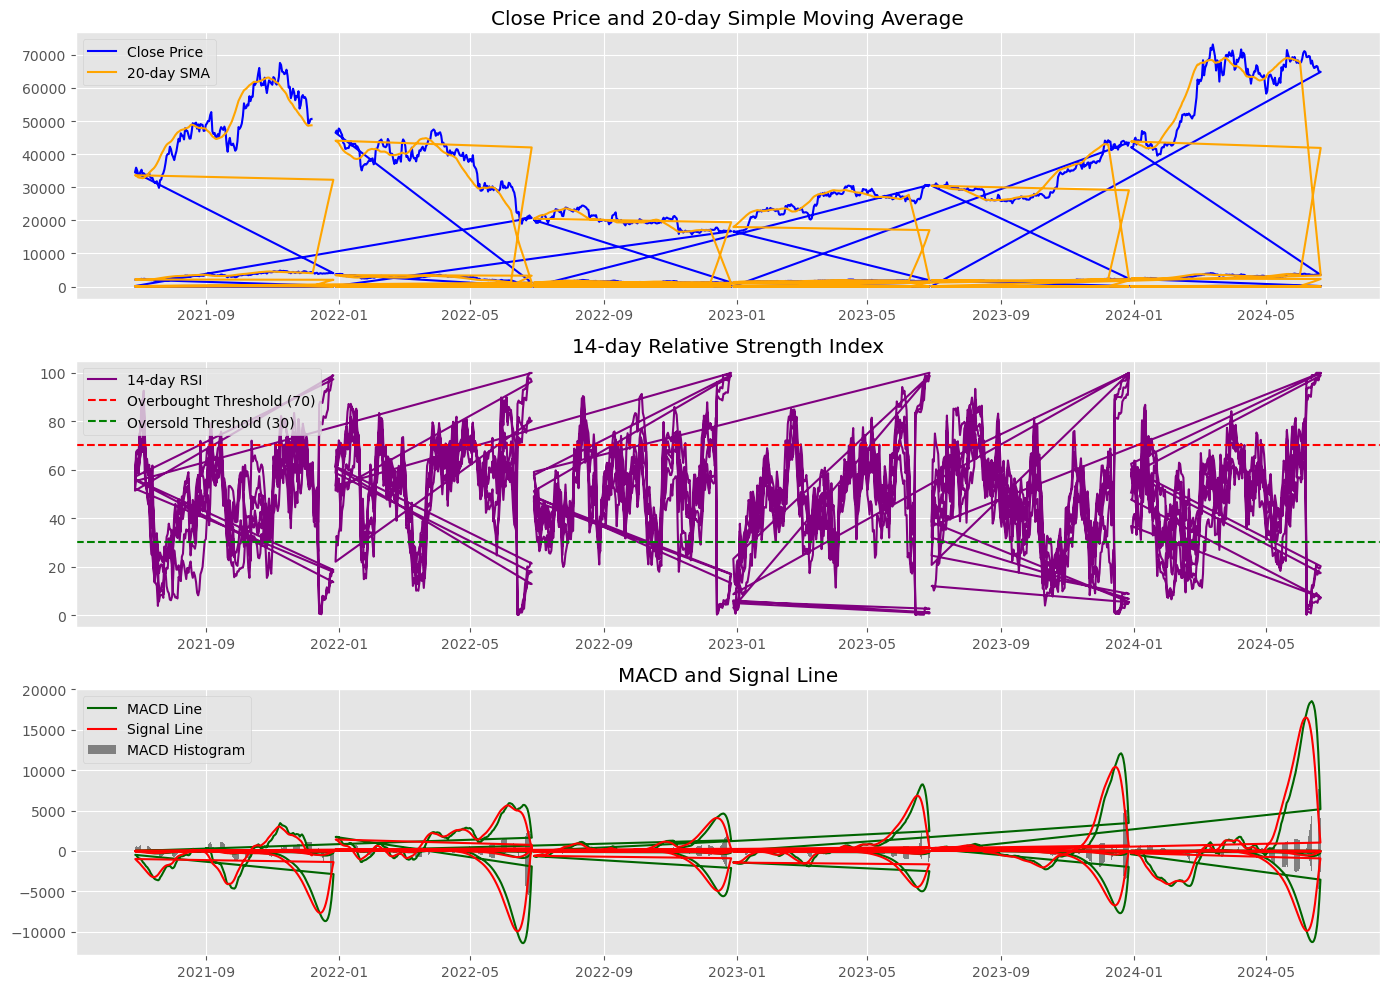

In [14]:
# Plotting Close Prices, SMA, RSI, and MACD
plt.figure(figsize=(14, 10))

# Subplot 1: Close Prices and SMA
plt.subplot(3, 1, 1)  # Three rows, one column, first subplot
plt.plot(clean_df['time'], clean_df['close'], label='Close Price', color='blue')
plt.plot(clean_df['time'], clean_df['sma_20'], label='20-day SMA', color='orange')
plt.title('Close Price and 20-day Simple Moving Average')
plt.legend()

# Subplot 2: RSI
plt.subplot(3, 1, 2)  # Three rows, one column, second subplot
plt.plot(clean_df['time'], clean_df['rsi_14'], label='14-day RSI', color='purple')
plt.axhline(70, color='red', linestyle='--', label='Overbought Threshold (70)')
plt.axhline(30, color='green', linestyle='--', label='Oversold Threshold (30)')
plt.title('14-day Relative Strength Index')
plt.legend()

# Subplot 3: MACD Line and Signal Line
plt.subplot(3, 1, 3)  # Three rows, one column, third subplot
plt.plot(clean_df['time'], clean_df['macd_line'], label='MACD Line', color='darkgreen')
plt.plot(clean_df['time'], clean_df['signal_line'], label='Signal Line', color='red')
plt.bar(clean_df['time'], clean_df['macd_histogram'], label='MACD Histogram', color='grey', width=0.5)
plt.title('MACD and Signal Line')
plt.legend()

plt.tight_layout()  # Adjust layout to not overlap
plt.show()


### Interpretation of Visualizations:
- Close Price and 20-day SMA:
The 20-day Simple Moving Average (SMA) smooths out the daily price fluctuations, highlighting broader trends in the market. It trails the closing price, confirming uptrends when the close is above the SMA and downtrends when below. Notably, sharp departures from the SMA may indicate overextended price movements, suggesting potential reversals.

- 14-day Relative Strength Index (RSI):
The RSI fluctuates significantly, crossing the overbought (70) and oversold (30) thresholds multiple times, indicating potential reversal points. Periods where the RSI remains above 70 or below 30 can signal strong momentum that might be unsustainable, pointing to possible price corrections.

- MACD and Signal Line:
The Moving Average Convergence Divergence (MACD) line and its signal line show the momentum by tracking the difference between two exponential moving averages (EMAs). Crossovers between the MACD line and the signal line are used as potential buy or sell signals. The histogram, representing the difference between the MACD line and the signal line, further emphasizes these points. When the histogram is above zero (MACD line above the signal line), it suggests bullish momentum, and below zero suggests bearish momentum.

## Lasso Regression to Identify Important Features

In [15]:
# Data preparation: Exclude 'time' and 'product_id' from features for model compatibility
X = clean_df.drop(['time', 'product_id'], axis=1)
y = clean_df['close']  # Target variable is 'close' price

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Creating and fitting a LassoCV regressor
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)

# Extracting feature importance and displaying important features with non-zero coefficients
feature_importance = pd.Series(index=X.columns, data=np.abs(lasso.coef_))
important_features = feature_importance[feature_importance > 0].sort_values(ascending=False)
print("Important features (non-zero coefficients):")
print(important_features)


Important features (non-zero coefficients):
low                  14043.097661
daily_price_range      445.589031
price_change           200.205563
high                    28.433686
close                    5.551369
open                     4.482108
net_daily_change         0.206728
dtype: float64


## Implementing Feature Reduction


In [16]:
# Reducing redundancy by dropping selected features
reduced_df = clean_df.drop(['high', 'open', 'net_daily_change'], axis=1)

# Display the revised DataFrame to confirm changes
print("Revised Data with Reduced Features:")
print(reduced_df.head())


Revised Data with Reduced Features:
        time      low     close        volume  price_change  average_price  \
0 2021-12-07  50067.1  50625.48  14107.332166         95.92      51031.050   
1 2021-12-06  47200.0  50529.56  23082.304656       1045.35      49152.500   
2 2021-12-05  47827.0  49484.22  21727.138212        248.96      48805.000   
3 2021-12-04  42333.0  49241.12  39023.329785      -4391.90      48104.545   
4 2021-12-03  51640.0  53638.04  19567.631138      -2883.41      54655.340   

   volatitlity product_id  year  month  day_of_week  percentage_change  \
0     3.850632    BTC-USD  2021     12            1           0.209423   
1     8.273305    BTC-USD  2021     12            0          -0.189470   
2     4.089740    BTC-USD  2021     12            6          -2.068769   
3    27.267356    BTC-USD  2021     12            5          -0.491268   
4    11.678311    BTC-USD  2021     12            4           8.929366   

       sma_20     rsi_14         ema12         ema

#### Evaluation of Columns:
- Time-Related: time, year, month, day_of_week are accurately reflecting temporal information, which is crucial for any time-series analysis or models that may capture seasonal or weekly patterns.

- Price Metrics: low, close, and average_price provide a comprehensive view of the price dynamics without redundancy. These features are essential for any financial analysis or predictive modeling regarding price movements.

- Volatility and Changes: volatitlity, price_change, and daily_price_range capture different aspects of market dynamics. volatitlity and daily_price_range give insights into the intra-day price movements and instability, while price_change offers a clear picture of the day-to-day market movement.

- Technical Indicators: sma_20, rsi_14, ema12, ema26, macd_line, signal_line, and macd_histogram provide a rich set of tools for analyzing trends and potential buy/sell signals. These are valuable for both straightforward trend following strategies and more complex predictive models.

- Trading Volume: volume is crucial as it can often be a leading indicator of price movements if analyzed in conjunction with price changes.

- Performance Metric: percentage_change is retained to measure the relative change in closing price, providing a direct performance metric that could be useful for predictive modeling.



### Multicollinearity Check

In [18]:
# Adding a constant column necessary for VIF calculation
X = add_constant(reduced_df.drop(['time', 'product_id'], axis=1))

# Calculating VIF for each feature in the DataFrame
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Printing the Variance Inflation Factor for each feature to assess multicollinearity
print("Variance Inflation Factor for each feature:")
print(vif_data)


Variance Inflation Factor for each feature:
              feature           VIF
0               const  5.914880e+06
1                 low           inf
2               close  1.765530e+04
3              volume  1.081512e+00
4        price_change  4.877264e+00
5       average_price           inf
6         volatitlity  1.225013e+00
7                year  1.332155e+00
8               month  1.277455e+00
9         day_of_week  1.034918e+00
10  percentage_change  1.488977e+00
11             sma_20  1.984699e+03
12             rsi_14  1.182991e+00
13              ema12           inf
14              ema26           inf
15          macd_line           inf
16        signal_line           inf
17     macd_histogram           inf
18  daily_price_range           inf


### Interpretation of VIF Results:
- Infinite VIF Values: Features such as low, average_price, ema12, ema26, macd_line, signal_line, macd_histogram, and daily_price_range show infinite VIF values, indicating extremely high multicollinearity. This is likely because these features are linear combinations of each other or very closely related (e.g., EMAs and MACD calculations are directly derived from close prices).

- High VIF for close and sma_20: Both features have very high VIF values, suggesting that they are highly linearly dependent with other variables in the model. Given their relationship to other moving averages and price metrics, this result is expected.

- Moderate to Low VIF for Other Features: Features like volume, price_change, volatitlity, and year, month, day_of_week, percentage_change, and rsi_14 show moderate to low VIF values, indicating acceptable levels of multicollinearity.



In [20]:
# List of columns to potentially drop
columns_to_drop = ['high', 'open', 'average_price', 'ema12', 'ema26', 'macd_line', 'signal_line']

# Dropping selected highly correlated features that exist in the DataFrame
reduced_df = reduced_df.drop([col for col in columns_to_drop if col in reduced_df.columns], axis=1)

# Display the revised DataFrame to confirm changes
print("Data with Reduced Features for Multicollinearity Mitigation:")
print(reduced_df.head())

# Adding a constant column necessary for VIF calculation
X = add_constant(reduced_df.drop(['time', 'product_id'], axis=1))

# Calculating VIF for each feature in the DataFrame
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Updated Variance Inflation Factor for each feature:")
print(vif_data)


Data with Reduced Features for Multicollinearity Mitigation:
        time      low     close        volume  price_change  volatitlity  \
0 2021-12-07  50067.1  50625.48  14107.332166         95.92     3.850632   
1 2021-12-06  47200.0  50529.56  23082.304656       1045.35     8.273305   
2 2021-12-05  47827.0  49484.22  21727.138212        248.96     4.089740   
3 2021-12-04  42333.0  49241.12  39023.329785      -4391.90    27.267356   
4 2021-12-03  51640.0  53638.04  19567.631138      -2883.41    11.678311   

  product_id  year  month  day_of_week  percentage_change      sma_20  \
0    BTC-USD  2021     12            1           0.209423  48704.1230   
1    BTC-USD  2021     12            0          -0.189470  48690.5115   
2    BTC-USD  2021     12            6          -2.068769  48643.3070   
3    BTC-USD  2021     12            5          -0.491268  48562.7940   
4    BTC-USD  2021     12            4           8.929366  48702.5860   

      rsi_14  macd_histogram  daily_price_r

### Interpretation of the Updated VIF Results:
- Significant Reduction in Multicollinearity: Most features now show reduced VIF values, suggesting that multicollinearity has been significantly mitigated by removing highly interdependent features. Features like rsi_14 and macd_histogram have very acceptable VIF values, indicating little to no multicollinearity concern.

- Persistent High VIF in Some Features: The low feature still exhibits a high VIF (16,553.86), which suggests it remains highly correlated with other features, likely close due to their inherent relationship. Similarly, daily_price_range shows a somewhat elevated VIF (20.83), which might still be problematic.



### Principal Component Analyssis (PCA)

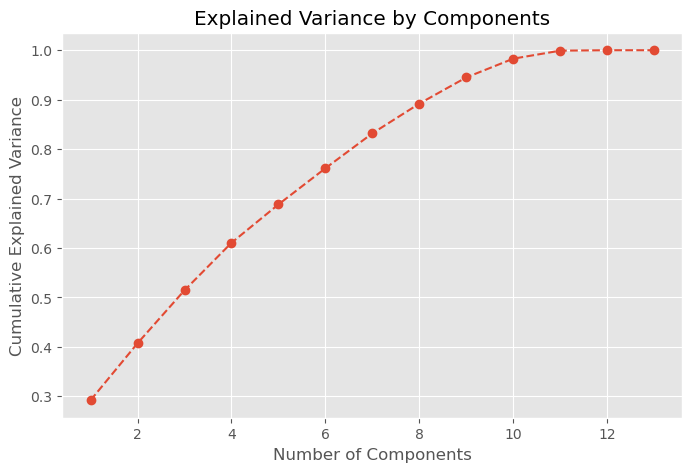

In [22]:
#Determine Optimal Number of PCA Components
# Preparing the data: dropping non-numeric and irrelevant features
X = reduced_df.drop(['time', 'product_id'], axis=1)
y = reduced_df['close']  # Assuming 'close' is the target variable

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fitting PCA
pca = PCA().fit(X_scaled)

# Plotting the cumulative sum of the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

#### Interpretation of the Explained Variance Plot:
- Rapid Increase: The plot shows a rapid increase in the cumulative explained variance with the initial few components, indicating that they capture a substantial amount of information about the dataset.
- Plateauing Trend: Around the 6th component, the increase in explained variance begins to plateau, suggesting that subsequent components add progressively less information.
- Near Complete Variance: By the time we reach 10 components, the cumulative explained variance is close to 90%, indicating that the majority of the dataset’s variance is captured by these components.

#### Applying PCA with 10 Components

In [23]:
# Preparing the data: dropping non-numeric and irrelevant features
X = reduced_df.drop(['time', 'product_id'], axis=1)
y = reduced_df['close']  # Assuming 'close' is the target variable

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Printing the shape of the new data matrix
print("New data shape after applying PCA with 10 components:", X_pca.shape)

New data shape after applying PCA with 10 components: (6827, 10)


The application of PCA to reduce the dataset to 10 principal components resulted in a new dataset shape of (6827, 10), confirming the dimensionality reduction was successful. Following this, a linear regression model was trained and tested using these components.

### Linear Regression Using PCA Components

In [25]:
# Splitting the PCA-transformed data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Setting up a linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predicting and evaluating the model
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the model performance metrics
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

Mean Squared Error (MSE): 3430706.5345959063
R-squared (R2): 0.9845913326353632


#### Interpretation of Linear Regression Model Results:
- Model Performance Metrics: The linear regression model achieved a Mean Squared Error (MSE) of approximately 3,430,706.53 and an R-squared (R²) value of 0.9846.
- MSE Interpretation: The MSE indicates the average squared difference between the predicted and actual closing prices. A lower MSE value would be indicative of a better fit to the data. Considering the scale of cryptocurrency price values, the magnitude of this MSE needs to be contextualized against the average price levels in the data.
- R² Interpretation: The R-squared value of approximately 0.9846 is quite high, suggesting that about 98.46% of the variance in the closing price is explained by the model. This indicates a strong fit to the data, demonstrating that the PCA components effectively capture the underlying trends and patterns relevant to predicting closing prices.